<a href="https://colab.research.google.com/github/befozg/AM_entrance/blob/main/classification_multi_lablel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Краткий отчет

Решение задачи можно разбить на 2 больших блока:

1) Предобработка данных

В данных есть много пропусков и категориальных признаков. В первую очередь было необходимо заполнить пропуски(заполнял средним по столбцу) и закодировать эти признаки. Принял решение кодировать LabelEncoder-ом, так как NaN-ов сильно много, и количественные методы (CountEncoding) дали бы сильно большие числа, что потом плохо могло бы повлиять на сходимость. Потом идет scaling данных для избежания градиентных взрывов, так как разброс в значениях очень большой. Ну и вдобавок, так как пространство сильно большое, применил PCA для уменьшения размерности. На самом деле я проверял и без PCA, разница в метриках не значительна, а в скорости очень большая, и без PCA есть коррелирующие признаки, которые надо в любом случае отобрать. 

2) Подходов несколько при multi-label задаче предсказания.

Первый подход - мы делаем предположение, что эти таргеты независимы, строим классификаторы для каждого таргета отдельно и обучаем их. Такой подход не всегда сработает хорошо, так как таргеты могут быть зависимы.

Второй подход - каждому набору  $\{0,1\}^{14}$  ->  $class_i$ , но тут такой подход плох тем, что классов будет в худшем случае  $2^{14}$ , что очень много.

В качестве модели тестировал ансамбль логрегрессий с беггингом (решающим деревом, xgboost-classifier-ом) и оверсемплингом, также тестировал нейросетку с и без lstm блока для сравнения. Ожидаемо хороший результат показал ансамбль, так как нейросетка из-за высокого имбаланса в данных сильно переобучалась негативные объекты. Конкретные метрики указаны в ноутбуке далее. При обучении использовал кросс-валидацию (в целом common practice).

После обучения моделей также смотрел вклады признаков дабы выкинуть совсем бесполезные. Делал экспериментов достаточно, но изначально предполагаемый беггинг с логрегрессиями/бустингом и sampling-ом дал лучший результат.

Чтобы избегать загромождений, некоторые поиски хороших параметров я убрал, оставляя уже найденные лучшие.


## Установка пакетов

In [ ]:
!pip install scikit-multilearn
!pip install category_encoders
!pip install seaborn
!pip install xgboost

     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 


## Предобработка

In [ ]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import scipy as sp
import numpy as np
import warnings
from category_encoders import CountEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
train_data_path='problem_train.csv'
test_data_path='problem_test.csv'
train_labels_path='problem_labels.csv'
test_labels_path='problem_test_labels.csv'

Подгрузка табличных данных:

In [ ]:
def load_data():
  train_data = pd.read_csv(train_data_path)
  train_labels = pd.read_csv(train_labels_path)
  test_data = pd.read_csv(test_data_path)
  return train_data, train_labels, test_data

train_data, train_labels, test_data = load_data()
train_data.head()

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,n_0009,n_0010,n_0011,n_0012,n_0013,n_0014,n_0015,n_0016,n_0017,n_0018,n_0019,n_0020,n_0021,n_0022,n_0023,n_0024,n_0025,n_0026,n_0027,n_0028,n_0029,n_0030,n_0031,n_0032,n_0033,n_0034,n_0035,n_0036,n_0037,...,c_1338,c_1339,c_1340,c_1341,c_1342,c_1343,c_1344,c_1345,c_1346,c_1347,c_1348,c_1349,c_1350,c_1351,c_1352,c_1353,c_1354,c_1355,c_1356,c_1357,c_1358,c_1359,c_1360,c_1361,c_1362,c_1363,c_1364,c_1365,c_1366,c_1367,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,NaN,NaN,NaN,NaN,0.292683,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223881,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,NaN,NaN,NaN,NaN,0.243902,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.472727,NaN,NaN,NaN,NaN,0.104478,0.125,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b,NaN,j,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,b,NaN,b,NaN,NaN,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,NaN,NaN,NaN,NaN,0.304878,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527273,NaN,NaN,NaN,NaN,0.119403,0.250,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c,NaN,a,NaN,NaN,NaN,NaN,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,NaN,NaN,NaN,NaN,0.207317,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149254,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a,NaN,j,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN,NaN,g,NaN,a,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,NaN,NaN,NaN,NaN,0.219512,NaN,NaN,NaN,NaN,0.388889,NaN,0.0,NaN,0.666667,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.072727,NaN,NaN,NaN,NaN,0.074627,NaN,NaN,0.0025,...,NaN,NaN,NaN,a,NaN,b,NaN,j,NaN,d,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,b,b,b,NaN,NaN,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN


Выкинем сразу столбец id

In [ ]:
train_data.drop("id", axis=1, inplace=True)
test_data.drop("id", axis=1, inplace=True)
train_labels.drop("id", axis=1, inplace=True)

In [ ]:
train_labels.head()

,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,0,0,0,1,1,0,0,0,0,0,1,1,1,0


На самом деле подходов несколько при multi-label задаче предсказания. 

Первый подход - мы делаем предположение, что эти таргеты независимы, строим классификаторы для каждого таргета отдельно и обучаем их. Такой подход не всегда сработает хорошо, так как таргеты могут быть зависимы.

Второй подход - каждому набору $\{0,1\}^{14}$ -> $class_i$, но тут такой подход плох тем, что классов будет в худшем случае $2^{14}$, что очень много.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 1378 entries, release to c_1377
dtypes: float64(345), int64(8), object(1025)
memory usage: 84.1+ MB


Закодируем категориальные фичи и заполним пропуски в данных. В данном подходе в категориальных фичах NaN будет считаться как отдельная категория.

In [ ]:
def encode_str_columns(data):
  for column in data.select_dtypes(include='object').columns:
      data[column] = LabelEncoder().fit_transform(data[column].astype('str'))
  return data

In [ ]:
# train_data.d()
train_data = encode_str_columns(train_data)
test_data = encode_str_columns(test_data)

In [ ]:
train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(test_data.mean(), inplace=True)
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

In [ ]:
train_data.head()

,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,n_0009,n_0010,n_0011,n_0012,n_0013,n_0014,n_0015,n_0016,n_0017,n_0018,n_0019,n_0020,n_0021,n_0022,n_0023,n_0024,n_0025,n_0026,n_0027,n_0028,n_0029,n_0030,n_0031,n_0032,n_0033,n_0034,n_0035,n_0036,n_0037,n_0038,...,c_1338,c_1339,c_1340,c_1341,c_1342,c_1343,c_1344,c_1345,c_1346,c_1347,c_1348,c_1349,c_1350,c_1351,c_1352,c_1353,c_1354,c_1355,c_1356,c_1357,c_1358,c_1359,c_1360,c_1361,c_1362,c_1363,c_1364,c_1365,c_1366,c_1367,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,0,0.307692,0.655744,0.025449,0.102749,0.352874,0.368421,0.193175,0.012012,0.422222,0.129241,0.361538,1.0,0.292683,0.375839,0.111511,0.036403,0.415251,0.453657,0.166667,0.0,0.447952,0.313725,0.031941,0.2,0.235887,0.004454,0.259406,0.136364,0.078173,0.283740,0.224112,0.150323,0.534413,0.415058,0.223881,0.140562,0.263636,0.003371,0.193548,...,2,4,9,2,2,1,3,11,8,6,1,1,5,1,2,3,10,2,4,2,2,2,1,4,2,1,4,2,6,1,3,11,3,2,0,5,17,13,2,2
1,0,0.307692,0.655744,0.031297,0.102749,0.352874,0.315789,0.193175,0.012012,0.422222,0.129241,0.361538,1.0,0.243902,0.375839,0.111511,0.036403,0.415251,0.453657,0.166667,0.0,0.447952,0.313725,0.031941,0.2,0.235887,0.004454,0.259406,0.136364,0.078173,0.472727,0.224112,0.150323,0.534413,0.415058,0.104478,0.125000,0.263636,0.003371,0.177419,...,2,4,9,2,2,1,3,9,8,6,1,1,5,1,2,3,10,2,4,2,2,2,1,4,2,1,4,1,6,1,3,11,0,2,0,5,14,13,2,2
2,0,0.307692,0.655744,0.024475,0.102749,0.352874,0.342105,0.193175,0.012012,0.422222,0.129241,0.361538,1.0,0.304878,0.375839,0.111511,0.036403,0.415251,0.453657,0.166667,0.0,0.447952,0.313725,0.031941,0.2,0.235887,0.004454,0.259406,0.136364,0.078173,0.527273,0.224112,0.150323,0.534413,0.415058,0.119403,0.250000,0.263636,0.003371,0.290323,...,2,4,9,2,2,0,3,11,8,6,1,1,5,1,2,3,10,2,4,2,2,2,1,2,2,0,4,2,6,1,3,11,0,2,0,5,1,13,2,2
3,0,0.307692,0.655744,0.041694,0.102749,0.352874,0.447368,0.193175,0.012012,0.422222,0.129241,0.361538,1.0,0.207317,0.375839,0.111511,0.036403,0.415251,0.453657,0.166667,0.0,0.447952,0.313725,0.031941,0.2,0.235887,0.004454,0.259406,0.136364,0.078173,0.283740,0.224112,0.150323,0.534413,0.415058,0.149254,0.140562,0.263636,0.003371,0.370968,...,2,4,9,2,2,0,3,9,8,6,1,1,5,1,2,3,0,2,4,2,2,2,1,6,2,0,4,1,6,1,3,11,3,2,0,5,14,13,2,2
4,2,0.307692,0.655744,0.038120,0.102749,0.352874,0.315789,0.193175,0.012012,0.422222,0.129241,0.361538,1.0,0.219512,0.375839,0.111511,0.036403,0.415251,0.388889,0.166667,0.0,0.447952,0.666667,0.031941,0.2,0.235887,0.000000,0.259406,0.136364,0.078173,0.072727,0.224112,0.150323,0.534413,0.415058,0.074627,0.140562,0.263636,0.002500,0.177419,...,2,4,9,0,2,1,3,9,8,3,1,1,5,1,2,3,10,2,4,2,2,2,1,4,2,1,1,1,6,1,3,11,1,2,0,5,0,13,2,2


Выделим тестовую выборку для оценки качества модели после обучения.

In [ ]:
def split_df(data, labels, train_size=8000):
  X_train, y_train = data.values[:train_size], labels.values[:train_size]
  X_val, y_val = data.values[train_size:], labels.values[train_size:]
  return X_train, y_train, X_val, y_val

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels)
X_train.shape, X_val.shape

((6000, 1378), (2000, 1378))

Для дальнейшей работы еще необходимо проверить на cкоррелированность фичей:

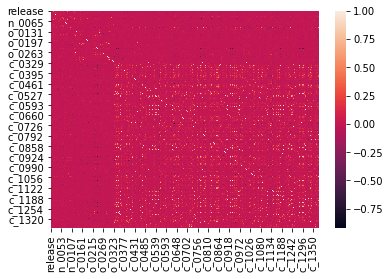

In [ ]:
corr = train_data.corr()
sns.heatmap(corr)
plt.show()

Корреляция невысокая между большей частью пар фичей. Пространство, вообще говоря, сильно большое. Для разумного времени работы моделей применим PCA и уменьшим размерность. 

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_val)
X_val = scaler.transform(X_val)


In [ ]:
pca = PCA(0.999)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
y_train = y_train.values
y_val = y_val.values

X_train_pca.shape

(6000, 1062)

Еще одна проблема, которую надо изучить - несбалансированность классов. Проверим.

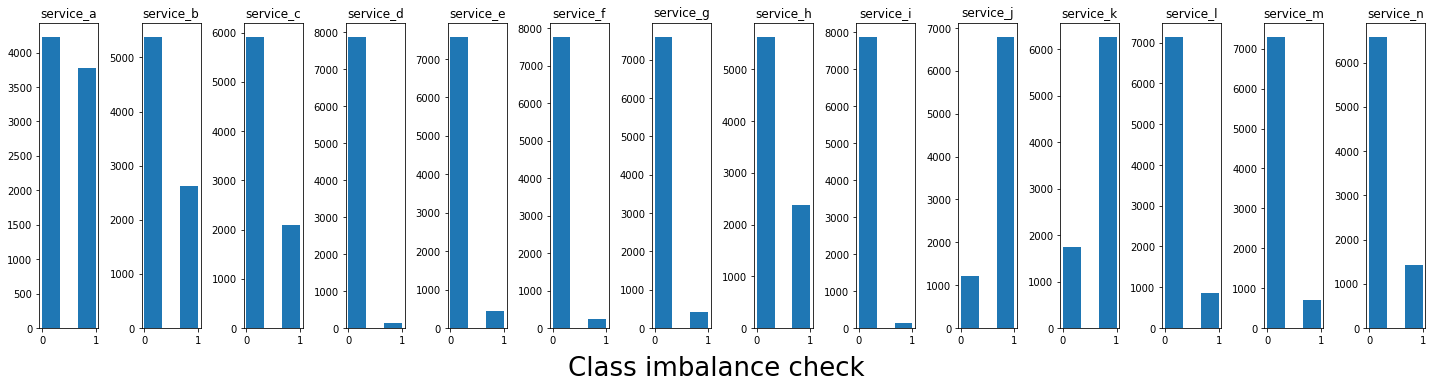

In [ ]:
fig, axes = plt.subplots(1, 14, figsize=(20, 5), tight_layout=True)
fig.suptitle('Class imbalance check', ha='center', fontsize=26, y=0)
for i, col in enumerate(train_labels.columns):
  axes[i].hist(train_labels[col], bins=3)
  axes[i].set_title(col, fontsize=12)
plt.show()

Видим, что у многих классов есть проблема несбалансированности. Попробую решить это  oversampling-ом. Но сначало посмотрим, будет ли существенная разница, если выкинуть выборочно некоторые объекты, приводящие к имбалансу.

In [ ]:
indexes_imb = train_labels.index[ (train_labels['service_a'] == 0) &
                      (train_labels['service_b'] == 0) &
                      (train_labels['service_c'] == 0) &
                      (train_labels['service_d'] == 0) &
                      (train_labels['service_e'] == 0) &
                      (train_labels['service_f'] == 0) &
                      (train_labels['service_g'] == 0) &
                      (train_labels['service_h'] == 0) &
                      (train_labels['service_i'] == 0) &
                      (train_labels['service_j'] == 1) &
                      (train_labels['service_k'] == 1) &
                      (train_labels['service_l'] == 0) &
                      (train_labels['service_m'] == 0) &
                      (train_labels['service_n'] == 0) ].tolist()
len(indexes_imb)

1807

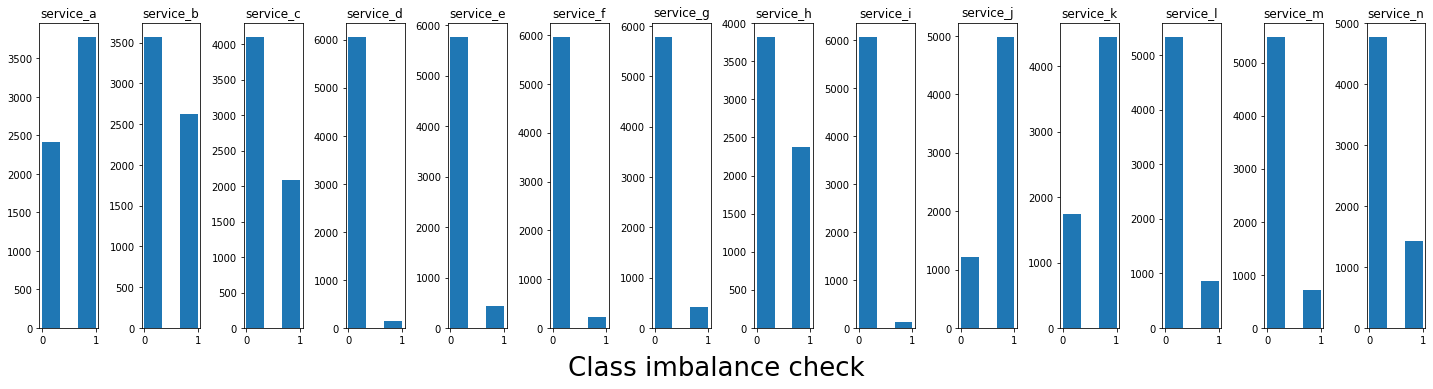

In [ ]:
dropped_data_labels = train_labels.drop(indexes_imb)

fig, axes = plt.subplots(1, 14, figsize=(20, 5), tight_layout=True)
fig.suptitle('Class imbalance check', ha='center', fontsize=26, y=0)
for i, col in enumerate(dropped_data_labels.columns):
  axes[i].hist(dropped_data_labels[col], bins=3)
  axes[i].set_title(col, fontsize=12)
plt.show()

Любопытно также смотреть, насколько коррелируют классы между собой.

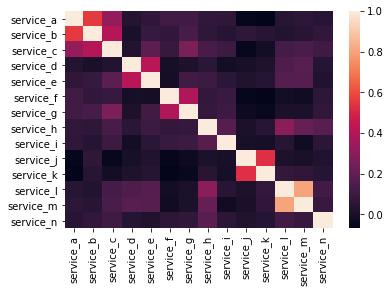

In [ ]:
corr = train_labels.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

In [ ]:
sp.stats.spearmanr(train_labels['service_k'], train_labels['service_j'])

SpearmanrResult(correlation=0.5335907040909952, pvalue=0.0)

Матрица корреляций показывает, что попарная скоррелированность есть только у $(service_a, service_b), (service_m, service_l), (service_j, service_k)$. Остальные не коррелируют. В таком случае вероятно, что отдельные классификаторы для каждого класса вполне могут хорошо предсказать.

# Модели


Функции для обучения/тестирования моделей:

In [ ]:
from sklearn.model_selection import KFold
from IPython.display import clear_output

def train_cv(model, X_train, y_train, n_splits=4, chain=False, batch_size=512):
  kfold = KFold(n_splits=n_splits, shuffle=True)
  accuracies = []
  losses = []
  f1_scores = []
  precisions = []
  recalls = []
  train_loss = []
  clf = None
  if chain:
    clf = ClassifierChain(model, order='random', random_state=0)
  else:
    clf = MultiOutputClassifier(model)
  for i, (train_idx, test_idx) in enumerate(kfold.split(X_train)):

    train_dataset = TensorDataset( Tensor(X_train[train_idx]), Tensor(y_train[train_idx]) )
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size)
    loss_avg = 0
    accuracy_avg = 0
    f1_avg = 0
    precision_avg = 0
    for j, (x_batch, y_batch) in enumerate(iter(train_data_loader)):
      
      clf.fit(x_batch, y_batch)
      y_prob_train = clf.predict_proba(x_batch)
      train_loss_avg = np.mean(log_losses(y_batch, y_prob_train))

      y_pred = clf.predict(X_train[test_idx])
      y_proba = clf.predict_proba(X_train[test_idx])

      loss_avg = np.mean(log_losses(y_train[test_idx], y_proba))
      accuracy_avg = np.mean(accuracy_scores(y_train[test_idx], y_pred))
      f1_avg = f1_score(y_train[test_idx], y_pred, average='samples')
      recall_avg = np.mean(recall_score(y_train[test_idx], y_pred, average='samples'))
      precision_avg = np.mean(precision_score(y_train[test_idx], y_pred, average='samples'))
      
      losses.append(loss_avg)
      accuracies.append(accuracy_avg)
      f1_scores.append(f1_avg)
      recalls.append(recall_avg)
      precisions.append(precision_avg)
      train_loss.append(train_loss_avg)

    print("Fold %d:" % i)
    print("Average loss: %f" % loss_avg)
    print("Average train loss: %f" % train_loss_avg)
    print("Average accuracy: %f" % accuracy_avg)
    print("Average f1-score: %f" % f1_avg)
    print("Average recall: %f" % recall_avg)
    print("Average precision: %f" % precision_avg)
    print()
    
    losses.append(loss_avg)
    accuracies.append(accuracy_avg)
    f1_scores.append(f1_avg)
    recalls.append(recall_avg)
    precisions.append(precision_avg)

  
  return clf, (losses, accuracies, f1_scores, recalls, precisions)

In [ ]:
def accuracy_scores(y_true, y_pred):
  
  return [accuracy_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]

def log_losses(y_true, y_proba):
  if (len(y_proba) == len(y_true) and len(y_proba[0]) == len(y_proba[0])):
    return [log_loss(y_true[:,i], y_proba[:,i], eps=0.001) for i in range(y_proba.shape[1])]
  
  return [log_loss(y_true[:,i], y_proba[i], eps=0.001) for i in range(len(y_proba))]


def multi_output_classifier_train(single_output_classifier, X_train, y_train):
  clf = MultiOutputClassifier(single_output_classifier).fit(X_train, y_train)
  
  return clf


def plot_roc_curve_multi(clf, X_val, y_val):

  fig = plt.figure(figsize=(12, 8))
  y_proba = clf.predict_proba(X_val)
  if(len(np.array(y_proba).shape) > 2):
    y_proba = np.array(y_proba)[:,:,1].T


  for i in range(14):
    fpr, tpr, _ = roc_curve(y_val[:,i],  y_proba[:,i])
    auc = roc_auc_score(y_val[:,i], y_proba[:,i])
    plt.plot(fpr, tpr, label="{}, AUC={:.3f}".format(i, auc))
      
  plt.plot([0,1], [0,1], color='orange', linestyle='--')

  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("False Positive Rate", fontsize=15)

  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=15)

  plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
  plt.legend(prop={'size':13}, loc='lower right')

  plt.show()

def test(clf, X_val, y_val):
  
  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  loss_avg = np.mean(log_losses(y_val, y_proba))
  accuracy_avg = np.mean(accuracy_scores(y_val, y_pred))
  f1_avg = f1_score(y_val, y_pred, average='samples')
  recall_avg = np.mean(recall_score(y_val, y_pred, average='samples'))
  precision_avg = np.mean(precision_score(y_val, y_pred, average='samples'))
     
  print("Average loss: %f" % loss_avg)
  print("Average accuracy: %f" % accuracy_avg)
  print("Average f1-score: %f" % f1_avg)
  print("Average recall: %f" % recall_avg)
  print("Average precision: %f" % precision_avg)
  
  plot_roc_curve_multi(clf, X_val, y_val)

  return y_pred, y_proba


# Bagging

Лучшая модель, что получилась - это сбалансирующий bagging ensemble логистических регрессий. Эта модель хорошо справляется с имбалансом, генерируя синтетические объекты по стратегии "из класса, который уступает по количеству". Лучшие параметры найдены random search-ом  и зафиксированы уже для удобства.

In [ ]:
X_train_pca.shape, y_train.shape

((6000, 702), (6000, 14))

In [177]:
warnings.filterwarnings('ignore')

lr_params = {
    'random_state': 0,
    'penalty': 'elasticnet',
    'max_iter': 100,
    'C': 1e-2,
    'solver': 'saga',
    'l1_ratio': 0.7
}

xbst_best_params = {
    'colsamplebytree': 0.75,
    'gamma': 0,
    'learning_rate': 0.02,
    'max_depth': 6, 
    'min_child_weight': 1, 
    'n_estimators': 100,
    'num_class': 2, 
    'objective': 'multi:softprob',
    'random_state':0, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'subsample':0.75, 
}


lr = LogisticRegression(**lr_params)
xgb_model = xgb.XGBClassifier(**xbst_best_params)

bbc_lr = BalancedBaggingClassifier(base_estimator=lr,
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=0)


bbc_lr_model, bbc_lr_metrix = train_cv(bbc_lr, 
                                      X_train_pca, 
                                      y_train, 
                                      batch_size=2000, 
                                      n_splits=3)


Fold 0:
Average loss: 0.411173
Average train loss: 0.403419
Average accuracy: 0.861357
Average f1-score: 0.699691
Average recall: 0.689266
Average precision: 0.794738

Fold 1:
Average loss: 0.382789
Average train loss: 0.376072
Average accuracy: 0.861464
Average f1-score: 0.695907
Average recall: 0.679076
Average precision: 0.799130

Fold 2:
Average loss: 0.399194
Average train loss: 0.391495
Average accuracy: 0.860964
Average f1-score: 0.695960
Average recall: 0.691363
Average precision: 0.786930



Average loss: 0.402100
Average accuracy: 0.858714
Average f1-score: 0.685302
Average recall: 0.677919
Average precision: 0.779708


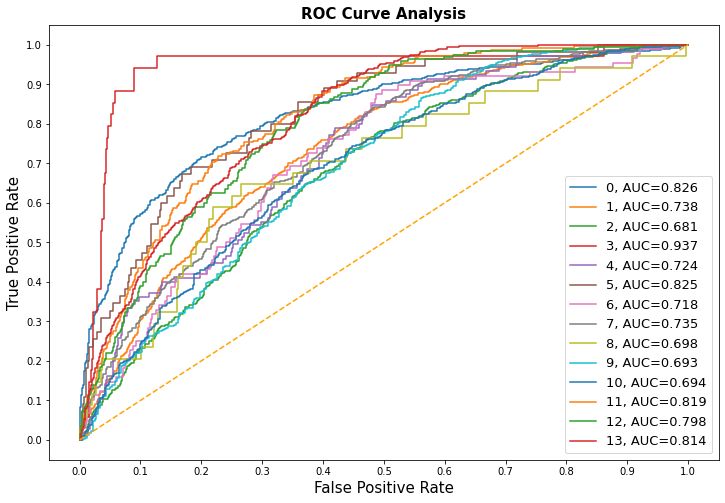

In [178]:
y_pred, y_proba = test(bbc_lr_model, X_val_pca, y_val)

In [179]:
X_test_pca = pca.transform(test_data)
y_pred = bbc_lr_model.predict(X_test_pca)
y_proba = np.array(bbc_lr_model.predict_proba(X_test_pca))
result = y_proba[:,:,1]
result = result.T

In [180]:
df_result = pd.DataFrame(result)
df_result.to_csv(test_labels_path)

Также ниже есть эксперименты с другими моделями(xgboost, decision tree и др,)

In [181]:
# тут сохранены лучшие параметры, подобранные grid_search-ом
xgb_clf = xgb.XGBClassifier(**xbst_best_params)
xgb_model, xgb_metrics = train_cv(xgb_clf, X_train_pca, y_train)

Fold 0:
Average loss: 0.360321
Average train loss: 0.129438
Average accuracy: 0.854238
Average f1-score: 0.674988
Average recall: 0.636444
Average precision: 0.815667

Fold 1:
Average loss: 0.364044
Average train loss: 0.125759
Average accuracy: 0.850714
Average f1-score: 0.657213
Average recall: 0.628819
Average precision: 0.779967

Fold 2:
Average loss: 0.370161
Average train loss: 0.128105
Average accuracy: 0.848714
Average f1-score: 0.674987
Average recall: 0.640363
Average precision: 0.806967

Fold 3:
Average loss: 0.361855
Average train loss: 0.128616
Average accuracy: 0.856810
Average f1-score: 0.675646
Average recall: 0.641995
Average precision: 0.807622



Average loss: 0.379956
Average accuracy: 0.845214
Average f1-score: 0.649471
Average recall: 0.616742
Average precision: 0.786636


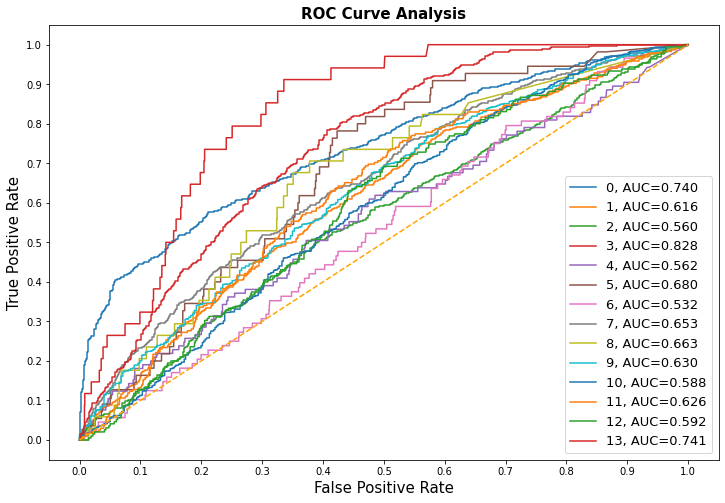

In [184]:
y_pred, y_proba = test(xgb_model, X_val_pca, y_val)

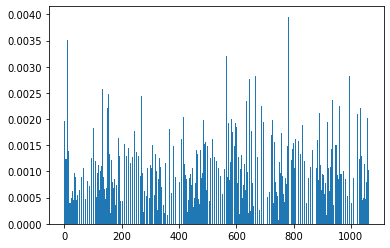

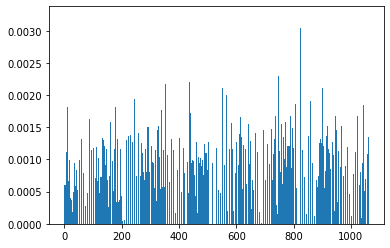

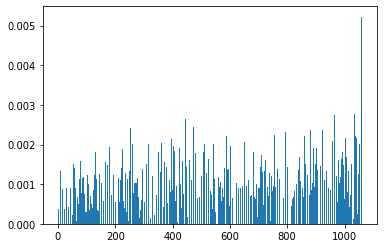

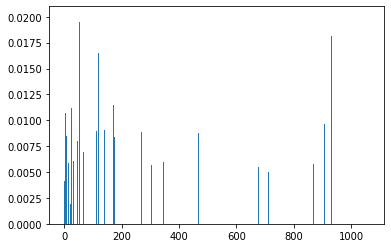

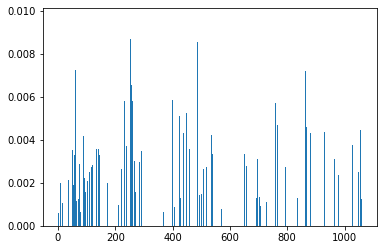

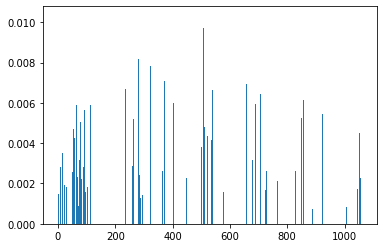

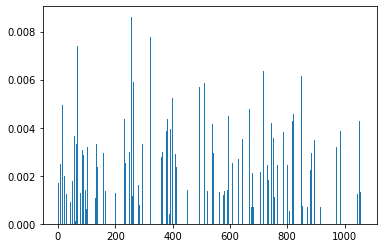

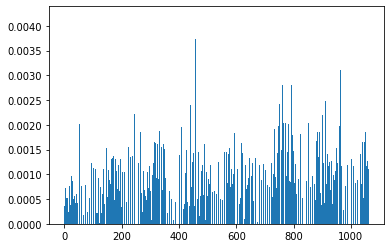

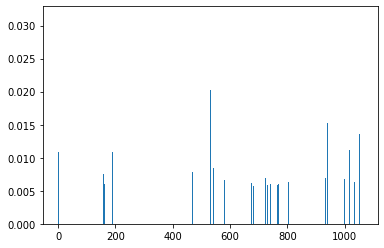

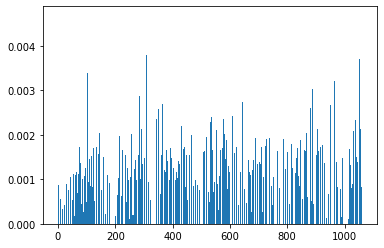

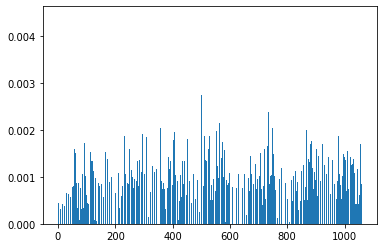

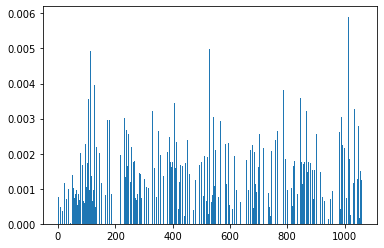

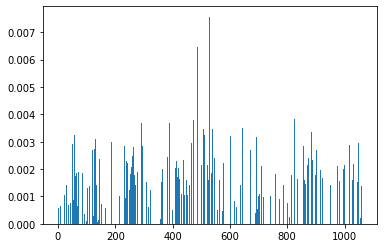

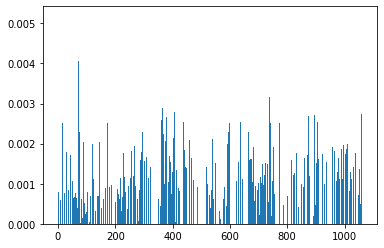

In [185]:
new = set()
for i in range(len(xgb_model.estimators_)):
  importance = xgb_model.estimators_[i].feature_importances_
  # plot feature importance
  plt.bar([x for x in range(len(importance))], importance)
  new = new | set([x for x in range(len(importance)) if importance[x] > 0 ])
  
  plt.show()

In [186]:
warnings.filterwarnings('ignore')

lr_params = {
    'random_state': 0,
    'penalty': 'elasticnet',
    'max_iter': 100,
    'C': 1e-2,
    'solver': 'saga',
    'l1_ratio': 0.7
}

clf = LogisticRegression(**lr_params)
lr_model, lr_metrics = train_cv(clf, X_train_pca, y_train, batch_size=2000)

Fold 0:
Average loss: 0.465211
Average train loss: 0.461506
Average accuracy: 0.857857
Average f1-score: 0.693132
Average recall: 0.674789
Average precision: 0.800633

Fold 1:
Average loss: 0.501820
Average train loss: 0.493213
Average accuracy: 0.854905
Average f1-score: 0.683844
Average recall: 0.666696
Average precision: 0.790122

Fold 2:
Average loss: 0.478855
Average train loss: 0.469770
Average accuracy: 0.853524
Average f1-score: 0.687591
Average recall: 0.669971
Average precision: 0.802067

Fold 3:
Average loss: 0.461463
Average train loss: 0.446456
Average accuracy: 0.848571
Average f1-score: 0.676592
Average recall: 0.653969
Average precision: 0.791000



Average loss: 0.460826
Average accuracy: 0.847607
Average f1-score: 0.667760
Average recall: 0.647273
Average precision: 0.783992


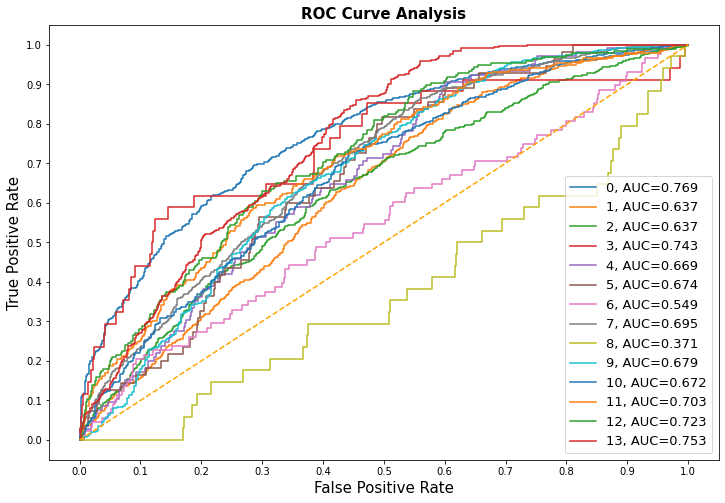

In [188]:
y_pred, y_proba = test(lr_model, X_val_pca, y_val)

In [189]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
bbc_tree = BalancedBaggingClassifier(base_estimator=tree,
                                sampling_strategy='not majority',
                                replacement=False,
                                # bootstrap=True,                              
                                random_state=0)


#Train the classifier.
bbc_tree_model, bbc_tree_metrics = train_cv(bbc_tree, X_train_pca, y_train, batch_size=2000, n_splits=3)

Fold 0:
Average loss: 0.377950
Average train loss: 0.144375
Average accuracy: 0.837893
Average f1-score: 0.650631
Average recall: 0.666438
Average precision: 0.724742

Fold 1:
Average loss: 0.369752
Average train loss: 0.147789
Average accuracy: 0.842143
Average f1-score: 0.663389
Average recall: 0.671623
Average precision: 0.742661

Fold 2:
Average loss: 0.375252
Average train loss: 0.145666
Average accuracy: 0.842964
Average f1-score: 0.665087
Average recall: 0.669611
Average precision: 0.750676



Average loss: 0.395053
Average accuracy: 0.819964
Average f1-score: 0.633795
Average recall: 0.650420
Average precision: 0.713413


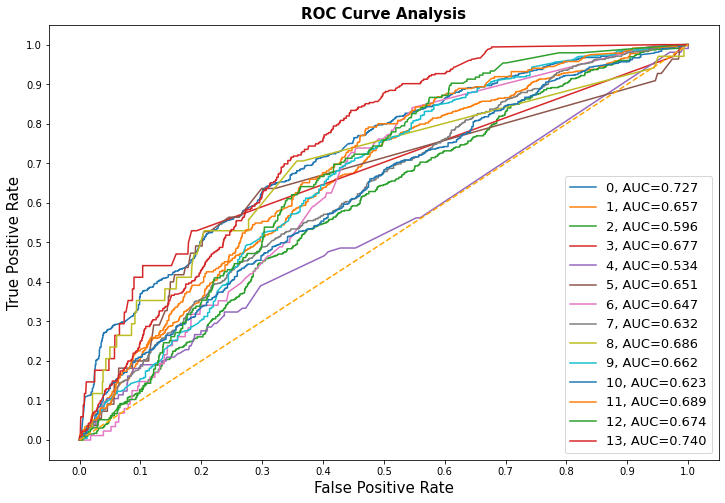

In [190]:
# model_tree = multi_output_classifier_train(tree, X_train, y_train)
y_pred, y_proba = test(bbc_tree_model, X_val_pca, y_val)

In [191]:
X_test_pca = pca.transform(test_data)
y_pred = bbc_tree_model.predict(X_test_pca)
y_proba = np.array(bbc_tree_model.predict_proba(X_test_pca))
result_tree = y_proba[:,:,1]
result_tree = result_tree.T

In [ ]:
df_result_tree = pd.DataFrame(result_tree)
df_result_tree.to_csv('tree.csv')

In [192]:
random_forest = RandomForestClassifier(random_state=0)
model_forest = multi_output_classifier_train(random_forest, X_train_pca, y_train)

Average loss: 0.367061
Average accuracy: 0.841857
Average f1-score: 0.653529
Average recall: 0.629258
Average precision: 0.776669


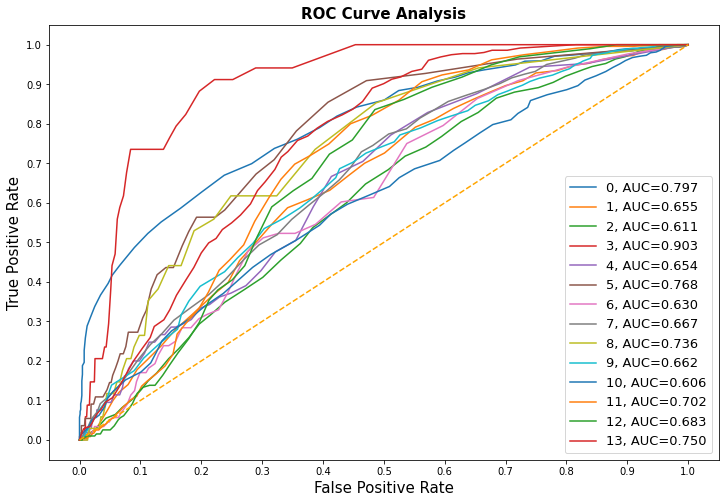

In [193]:
y_pred, y_proba = test(model_forest, X_val_pca, y_val)

# 2 подход
Проверим как работает на LabelPowerset на нашем датасете. То есть каждый возможный вектор из 14-и классов кодируется как отдельный метакласс и обучается модель обычной классификации.

In [ ]:
X_train.shape

(6000, 1378)

In [194]:
classifier = LabelPowerset(DecisionTreeClassifier(max_depth=10, random_state=0))
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_val_pca)

In [195]:
from sklearn.metrics import accuracy_score, log_loss

y_pred = classifier.predict(X_val_pca).toarray()
y_proba = classifier.predict_proba(X_val_pca).toarray()

In [196]:
loss_avg = np.mean([log_loss(y_val[:,i], y_proba[:,i]) for i in range(y_proba.shape[1])])
accuracy_avg = np.mean(accuracy_scores(y_val, y_pred))
f1_avg = f1_score(y_val, y_pred, average='samples')

print("Average f1-score: %f" % f1_avg)
print("Average loss: %f" % loss_avg)
print("Average accuracy: %f" % accuracy_avg)

Average f1-score: 0.624992
Average loss: 1.716728
Average accuracy: 0.831071


Ожидаемо высокий loss, так как в тесте появляются новые комбинации классов, которых модель не видел, также проблема парадокса accuracy возникла.

Еще один важный вариант, который довольно неплохо работает, это цепочка классификаторов, обучающихся на датасете и результатах предыдущих. Построим цепочку из логистических регрессий и проверим это.

In [197]:
from sklearn.multioutput import ClassifierChain

In [198]:
chain = LogisticRegression(random_state=0, solver='liblinear', max_iter=200)
chain, metrics_chain = train_cv(chain, X_train_pca, y_train, chain=True)

Fold 0:
Average loss: 0.853616
Average train loss: 0.010338
Average accuracy: 0.754048
Average f1-score: 0.561373
Average recall: 0.663200
Average precision: 0.567544

Fold 1:
Average loss: 0.875787
Average train loss: 0.009918
Average accuracy: 0.751048
Average f1-score: 0.565700
Average recall: 0.659282
Average precision: 0.574743

Fold 2:
Average loss: 0.856465
Average train loss: 0.009679
Average accuracy: 0.755952
Average f1-score: 0.581981
Average recall: 0.673202
Average precision: 0.595141

Fold 3:
Average loss: 0.869089
Average train loss: 0.010069
Average accuracy: 0.752476
Average f1-score: 0.573090
Average recall: 0.663646
Average precision: 0.585597



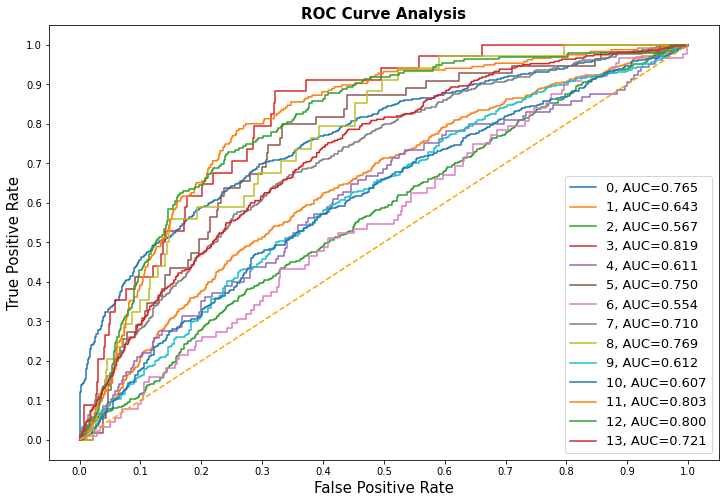

In [199]:
y_pred = chain.predict(X_val_pca)
y_proba = chain.predict_proba(X_val_pca)
plot_roc_curve_multi(chain, X_val_pca, y_val)

In [200]:
loss_avg = np.mean([log_loss(y_val[:,i], y_proba[:,i]) for i in range(y_proba.shape[1])])
accuracy_avg = np.mean(accuracy_scores(y_val, y_pred))
f1_avg = f1_score(y_val, y_pred, average='samples')

print("Average f1-score: %f" % f1_avg)
print("Average loss: %f" % loss_avg)
print("Average accuracy: %f" % accuracy_avg)

Average f1-score: 0.566914
Average loss: 0.963829
Average accuracy: 0.759000


# DL

In [205]:
X_train.shape

(6000, 1378)

In [207]:
pca = PCA(0.999)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.999, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [208]:
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

X, y = X_train_pca, y_train
X.shape, y.shape

((6000, 1062), (6000, 14))

In [209]:
X.shape, y.shape

((6000, 1062), (6000, 14))

In [210]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU, Sigmoid, LSTM, Dropout, Module, GRU, BatchNorm1d
from sklearn.model_selection import KFold
import torch.optim as optim


class Reshape(nn.Module): 
  def __init__(self, *args): 
    
    super(Reshape, self).__init__() 
    self.shape = args 

  def forward(self, x): 
    
    if(self.shape[0] == 1 and len(self.shape) == 3 and self.shape[1] * self.shape[2] != x.shape[0] * x.shape[1]):
      return  x.view((self.shape[0], (x.shape[0] * x.shape[1]) // self.shape[2], self.shape[2]))

    return x.view(self.shape) 

In [211]:
BATCH_SIZE=400
net_LSTM = Sequential(
    Linear(X.shape[1], 512),
    ReLU(),
    BatchNorm1d(512),
    Linear(512, BATCH_SIZE),
    ReLU(),
    Dropout(),
    Reshape(1, BATCH_SIZE, BATCH_SIZE),
    flightLSTM(BATCH_SIZE, 128, 1),
    Reshape(-1, 128),
    ReLU(),
    Dropout(),
    Linear(128, 64),
    ReLU(),
    Dropout(),
    Linear(64, train_labels.shape[1]),
    Sigmoid()
)

net_linear = Sequential(
    Linear(X.shape[1], 256),
    ReLU(),
    BatchNorm1d(256),
    Linear(256, 128),
    ReLU(),
    Dropout(),
    Linear(128, 64),
    ReLU(),
    Dropout(),
    Linear(64, train_labels.shape[1]),
    Sigmoid()
)
net_linear

Sequential(
  (0): Linear(in_features=1062, out_features=256, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=14, bias=True)
  (10): Sigmoid()
)

In [212]:
criterion_linear = torch.nn.MSELoss()
optimizer_linear = optim.Adam(net_linear.parameters(), lr=0.001)

criterion_lstm = torch.nn.MSELoss()
optimizer_lstm = optim.Adam(net_LSTM.parameters(), lr=0.001)

In [213]:
def probs_to_label(prob):
  return 1. if prob > 0.5 else 0.;

probs_to_label_vectorized = np.vectorize(probs_to_label)

def evaluate_model(model, X, y, criterion, optimizer, n_splits=5, batch_size=BATCH_SIZE, epochs=40):
  results = []

  n_inputs, n_outputs = X.shape[1], y.shape[1]
  kfold = KFold(n_splits=n_splits, shuffle=True)
  accuracies = []
  losses = []
  f1_scores = []
  precisions = []
  recalls = []
  X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
  for i, (train_ix, test_ix) in enumerate(kfold.split(X)):

    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    dataset = TensorDataset( Tensor(X_train), Tensor(y_train) )
    data_loader = DataLoader(dataset, batch_size=batch_size)

    model.train()
    for epoch in range(epochs):#epoch
      # print(epoch)
      for j, (x_batch, y_batch) in enumerate(iter(data_loader)):
        # print(x.shape)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x_batch)
        # print(outputs.shape, y_train.shape)

        loss = criterion(outputs, y_batch)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    test_dataset = TensorDataset( Tensor(X_test), Tensor(y_test) )
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size)
    loss_avg = 0
    accuracy_avg = 0
    f1_avg = 0
    for j, (x_batch, y_batch) in enumerate(iter(test_data_loader)):

      y_prob = model(x_batch).detach().numpy()
      y_pred = probs_to_label_vectorized(y_prob)
      loss_avg = np.mean(log_losses(y_batch, y_pred))
      accuracy_avg = np.mean(accuracy_scores(y_batch, y_pred))
      f1_avg = f1_score(y_batch, y_pred, average='samples')
      recall_avg = np.mean(recall_score(y_batch, y_pred, average='samples'))
      precision_avg = np.mean(precision_score(y_batch, y_pred, average='samples'))
      
      losses.append(loss_avg)
      accuracies.append(accuracy_avg)
      f1_scores.append(f1_avg)
      recalls.append(recall_avg)
      precisions.append(precision_avg)
    
    print("Fold %d:" % i)
    print("Average loss: %f" % np.mean(loss_avg))
    print("Average accuracy: %f" % np.mean(accuracy_avg))
    print("Average f1-score: %f" % np.mean(f1_avg))
    print("Average recall: %f" % np.mean(recall_avg))
    print("Average precision: %f" % np.mean(precision_avg))
    


  fig, axs = plt.subplots(1, 3, figsize=(12, 8))
  fig.suptitle('Training')
  axs[0].plot(range(len(losses)), losses)
  axs[0].set_title('loss')
  axs[1].plot(range(len(accuracies)), accuracies)
  axs[1].set_title('accuracy')
  axs[2].plot(range(len(f1_scores)), f1_scores)
  axs[2].set_title('f1-score')
  return model, losses, accuracies, f1_scores

Fold 0:
Average loss: 0.992613
Average accuracy: 0.856429
Average f1-score: 0.709884
Average recall: 0.732686
Average precision: 0.773833
Fold 1:
Average loss: 0.382105
Average accuracy: 0.944821
Average f1-score: 0.868413
Average recall: 0.877332
Average precision: 0.893449
Fold 2:
Average loss: 0.216837
Average accuracy: 0.968750
Average f1-score: 0.927158
Average recall: 0.925601
Average precision: 0.948202
Fold 3:
Average loss: 0.176136
Average accuracy: 0.974643
Average f1-score: 0.942759
Average recall: 0.940150
Average precision: 0.959342
Fold 4:
Average loss: 0.110769
Average accuracy: 0.984107
Average f1-score: 0.964196
Average recall: 0.964682
Average precision: 0.971667


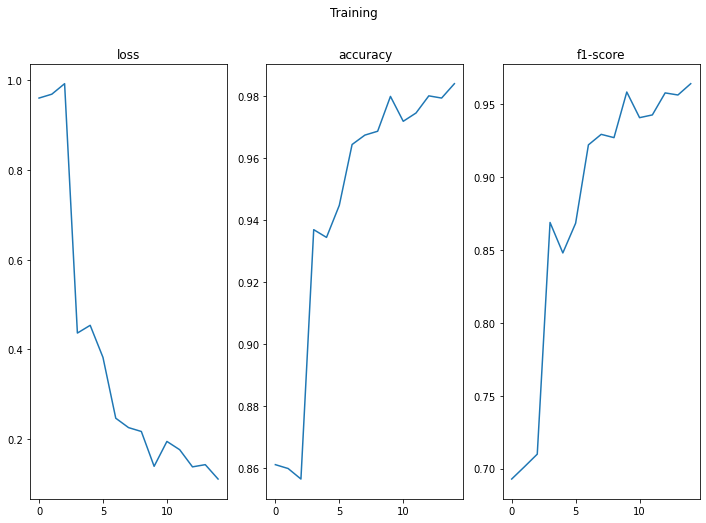

In [214]:
net_linear, losses, accuracies, f1_scores = evaluate_model(net_linear, X, y, criterion_linear, optimizer_linear)

Fold 0:
Average loss: 0.949446
Average accuracy: 0.862679
Average f1-score: 0.694622
Average recall: 0.715780
Average precision: 0.752812
Fold 1:
Average loss: 0.520240
Average accuracy: 0.924821
Average f1-score: 0.839460
Average recall: 0.839494
Average precision: 0.877657
Fold 2:
Average loss: 0.285904
Average accuracy: 0.958750
Average f1-score: 0.906223
Average recall: 0.903642
Average precision: 0.930046
Fold 3:
Average loss: 0.229170
Average accuracy: 0.966964
Average f1-score: 0.916467
Average recall: 0.915650
Average precision: 0.935700
Fold 4:
Average loss: 0.216837
Average accuracy: 0.968750
Average f1-score: 0.933940
Average recall: 0.929126
Average precision: 0.958765


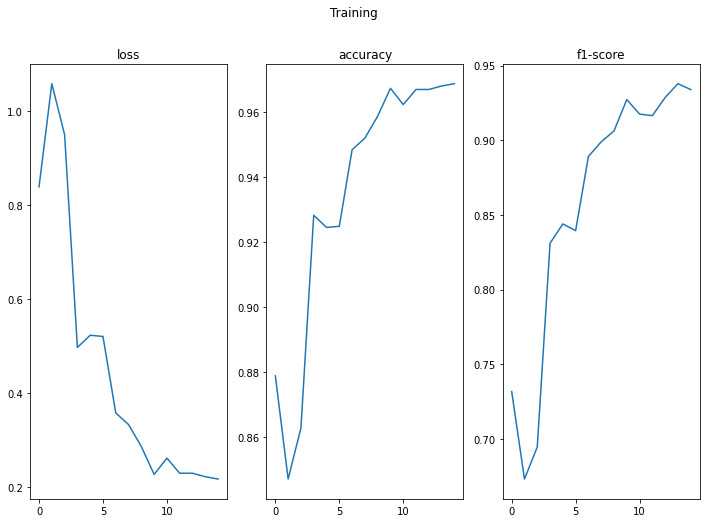

In [215]:
net_LSTM, losses, accuracies, f1_scores = evaluate_model(net_LSTM, X, y, criterion_lstm, optimizer_lstm)

In [216]:
net_linear.eval()
test_dataset = TensorDataset( Tensor(X_val_pca), Tensor(y_val) )
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
loss_avg = 0
accuracy_avg = 0
f1_avg = 0
losses=[]
accuracies=[]
f1_scores=[]
for j, (x_batch, y_batch) in enumerate(iter(test_data_loader)):
  y_prob = net_linear(x_batch).detach().numpy()
  y_pred = probs_to_label_vectorized(y_prob)
  loss_avg = log_losses(y_batch, y_pred)
  accuracy_avg = accuracy_scores(y_batch, y_pred)
  f1_avg = f1_score(y_batch, y_pred, average='samples')

  losses.append(loss_avg)
  accuracies.append(accuracy_avg)
  f1_scores.append(f1_avg)

print("Average loss: %f" % np.mean(losses))
print("Average accuracy: %f" % np.mean(accuracies))
print("Average f1-score: %f" % np.mean(f1_scores))


Average loss: 1.019007
Average accuracy: 0.852607
Average f1-score: 0.682221


In [217]:
net_LSTM.eval()
test_dataset = TensorDataset( Tensor(X_val_pca), Tensor(y_val) )
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
loss_avg = 0
accuracy_avg = 0
f1_avg = 0
losses=[]
accuracies=[]
f1_scores=[]
for j, (x_batch, y_batch) in enumerate(iter(test_data_loader)):
  y_prob = net_LSTM(x_batch).detach().numpy()
  y_pred = probs_to_label_vectorized(y_prob)
  loss_avg = log_losses(y_batch, y_pred)
  accuracy_avg = accuracy_scores(y_batch, y_pred)
  f1_avg = f1_score(y_batch, y_pred, average='samples')

  losses.append(loss_avg)
  accuracies.append(accuracy_avg)
  f1_scores.append(f1_avg)

print("Average loss: %f" % np.mean(losses))
print("Average accuracy: %f" % np.mean(accuracies))
print("Average f1-score: %f" % np.mean(f1_scores))


Average loss: 0.975100
Average accuracy: 0.858964
Average f1-score: 0.698193


В целом я априори был настроен решить задачу через классические методы машинного обучения, так как их интерпретировать лучше получается нежели dl. Ну и dl дал гораздо хуже лосс, поэтому остановился на ML.